In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(purrr)
library(splines)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
all_event_wide_lists_withoutavg_1_8 <- readRDS("all_event_wide_lists_withoutavg_1_8.RDS")
data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]]

In [5]:
# 读取数据并整理长格式
meta_cols <- c("GeneID","geneSymbol","chr","strand",
               "exonStart_0base","exonEnd","upstreamES","upstreamEE","downstreamES","downstreamEE")
# data_list <- readRDS("bo_all_SE_data.RDS")
psi_cols <- setdiff(colnames(data_list), meta_cols)


In [6]:
print(data_list)

# A tibble: 313,801 × 153
   GeneID  geneSymbol chr   strand exonStart_0base exonEnd upstreamES upstreamEE
   <chr>   <chr>      <chr> <chr>            <dbl>   <dbl>      <dbl>      <dbl>
 1 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 2 LOC105… NA         chrN… -             10468017  1.05e7   10464238   10466866
 3 LOC105… NA         chrN… -             10472028  1.05e7   10468017   10468077
 4 LOC105… NA         chrN… -             10473456  1.05e7   10472028   10472230
 5 LOC105… NA         chrN… -             10480619  1.05e7   10473456   10473574
 6 LOC101… NA         chrN… -             10459418  1.05e7   10458419   10458691
 7 LOC101… NA         chrN… -             10459418  1.05e7   10458419   10458691
 8 LOC101… NA         chrN… -             10162484  1.02e7   10161581   10161647
 9 LOC101… NA         chrN… -             10165718  1.02e7   10164510   10164656
10 LOC101… NA         chrN… -             10175186  1.02e7   10166288   10166496
# 

In [7]:
    # 设定发育阶段自定义顺序
    custom_order <- c(
      "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days", "Egg-36_hours", 
      "Egg-3_days", "Egg-72_hours", "Egg-120_hours", "Egg-168_hours", "Egg-192_hours", "Egg-216_hours", 
      "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours", "Larva-1_instar", 
      "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", 
      "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar", 
      "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", 
      "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", 
      "Larva-5_instar", "Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar", 
      "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", 
      "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage",
      "Larva-52h_wandering_stage", "Pupa-stage_5", 
      "Adult-0h", "Adult-1_day", "Adult-2_days", "Adult-4_days", "Adult-5_days"
    )

In [8]:

# 数据整理：宽转长、拆分列、处理PSI值
data_long_parsed2 <- data_list %>%
  select(all_of(meta_cols), all_of(psi_cols)) %>%
  pivot_longer(
    cols      = all_of(psi_cols),
    names_to  = "Stage_Tissue",
    values_to = "PSI_string"
  ) %>%
  separate_rows(PSI_string, sep = ",") %>%
  mutate(PSI_value = as.numeric(PSI_string)) %>%
  filter(!is.na(PSI_value)) %>%
  group_by(GeneID, Stage_Tissue) %>%
  summarise(PSI_value = mean(PSI_value), .groups="drop") %>%
  separate(
    col  = Stage_Tissue,
    into = c("Stage","Stage_xifen","Tissue"),
    sep  = "__",
    remove = FALSE
  ) %>%
  mutate(
    Stage = if_else(Stage == "Cell", "Egg", Stage),
    Tissue = if_else(Tissue %in% c("Egg","Pupa"), "Whole_body", Tissue),
    Stage = factor(Stage, levels = c("Egg","Larva","Pupa","Adult")),
    Combined_Stage = paste(Stage, Stage_xifen, sep = "-")
  ) %>%
  filter(Combined_Stage %in% custom_order) %>%
  mutate(Combined_Stage = factor(Combined_Stage, levels = custom_order)) %>%
  arrange(Stage, Stage_xifen)


In [9]:
print(data_long_parsed2)

# A tibble: 403,561 × 7
   GeneID     Stage_Tissue     Stage Stage_xifen Tissue PSI_value Combined_Stage
   <chr>      <chr>            <fct> <chr>       <chr>      <dbl> <fct>         
 1 14-3-3zeta Egg__0_days__Egg Egg   0_days      Whole…     0.130 Egg-0_days    
 2 ACBP       Egg__0_days__Egg Egg   0_days      Whole…     0.960 Egg-0_days    
 3 AK         Egg__0_days__Egg Egg   0_days      Whole…     0.105 Egg-0_days    
 4 Alg-2      Egg__0_days__Egg Egg   0_days      Whole…     0.996 Egg-0_days    
 5 Anxb13     Egg__0_days__Egg Egg   0_days      Whole…     0.552 Egg-0_days    
 6 Apaf-1     Egg__0_days__Egg Egg   0_days      Whole…     1     Egg-0_days    
 7 Borealin   Egg__0_days__Egg Egg   0_days      Whole…     0.997 Egg-0_days    
 8 CDC2L1     Egg__0_days__Egg Egg   0_days      Whole…     0.002 Egg-0_days    
 9 CDK2       Egg__0_days__Egg Egg   0_days      Whole…     0.905 Egg-0_days    
10 CHD1       Egg__0_days__Egg Egg   0_days      Whole…     0.991 Egg-0_days    
# ℹ 

In [10]:
# 提取 Whole_body 作为基准数据
df_whole <- data_long_parsed2 %>%
  filter(Tissue == "Whole_body") %>%
  select(GeneID, Combined_Stage, PSI_whole = PSI_value)

In [11]:
window_size <- 5


In [12]:
# 获取非 Whole_body 的所有组织
tissue_list <- unique(data_long_parsed2$Tissue[data_long_parsed2$Tissue != "Whole_body"])

In [13]:
# 构造结果数据框：每个组织、每个中心阶段（custom_order）均计算一次滚动相关性
corr_results <- expand.grid(Tissue = tissue_list,
                            Combined_Stage = custom_order,
                            stringsAsFactors = FALSE) %>%
  as_tibble() %>%
  mutate(stage_index = match(Combined_Stage, custom_order))

In [14]:
# 定义函数：给定组织和中心阶段索引，利用窗口内（中心及相邻阶段）数据计算相关性
compute_rolling_cor <- function(tissue, center_index, window_size, custom_order, data_long_parsed2, df_whole) {
  half_window <- floor(window_size / 2)
  start_index <- max(1, center_index - half_window)
  end_index   <- min(length(custom_order), center_index + half_window)
  window_stages <- custom_order[start_index:end_index]
  
  # 对于该组织，窗口内各阶段的PSI值合并后按GeneID取均值（同一基因在窗口内可能多次出现）
  df_tissue <- data_long_parsed2 %>%
    filter(Tissue == tissue, Combined_Stage %in% window_stages) %>%
    group_by(GeneID) %>%
    summarise(PSI_tissue = mean(PSI_value), .groups = "drop")
  
  # 对于基准Whole_body，同样取窗口内数据，并按GeneID取均值
  df_baseline <- df_whole %>%
    filter(Combined_Stage %in% window_stages) %>%
    group_by(GeneID) %>%
    summarise(PSI_whole = mean(PSI_whole), .groups = "drop")
  
  # 按GeneID内连接，保留两边都有的基因
  df_joined <- inner_join(df_tissue, df_baseline, by = "GeneID")
  
  # 若数据对少于3个，则返回NA；否则计算皮尔逊相关系数
  if(nrow(df_joined) < 3) {
    return(NA_real_)
  } else {
    return(cor(df_joined$PSI_tissue, df_joined$PSI_whole, use = "pairwise.complete.obs"))
  }
}

In [15]:
# 对每个组织和中心阶段计算滚动相关性
corr_results <- corr_results %>%
  mutate(cor_value = map2_dbl(Tissue, stage_index,
                              ~ compute_rolling_cor(.x, .y, window_size, custom_order, data_long_parsed2, df_whole)),
         Combined_Stage = factor(Combined_Stage, levels = custom_order))

In [16]:
corr_results<- corr_results %>%
  group_by(Combined_Stage) %>%
  filter(!all(is.na(cor_value))) %>%
  ungroup()


In [17]:
corr_results_filtered <- corr_results %>%
  mutate(Stage_numeric = as.numeric(Combined_Stage))


In [21]:
# 新增颜色映射部分 ------------------------------------------------------------
# 检查/创建颜色映射文件
if (file.exists("tissue_color_mapping.rds")) {
  tissue_color_mapping <- readRDS("tissue_color_mapping.rds")
} else {
  tissue_color_mapping <- setNames(character(), character())
}
# 获取当前组织列表（排除可能的NA值）
current_tissues <- na.omit(unique(corr_results_filtered$Tissue))
# 颜色候选池（保持原顺序）
color_pool <- c(
  "#E41A1C","#377EB8","#984EA3","#8DA0CB","#4DAF4A","#FF7F00","#FFFF33","#A65628",
  "#F781BF","#999999","#66C2A5","#FC8D62","#A6D854","#FFD92F","#E5C494",
  "#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
  "#D9D9D9","#BC80BD","#CCEBC5","#FFED6F"
)
# 更新颜色映射函数（保持颜色池顺序）
update_color_mapping <- function(existing_mapping, new_tissues, color_pool) {
  # 已用颜色按color_pool顺序排列
  used_colors <- intersect(color_pool, unname(existing_mapping))
  
  # 可用的颜色按color_pool顺序筛选
  available_colors <- setdiff(color_pool, used_colors)
  
  # 分配新颜色时保持color_pool顺序
  new_mapping <- setNames(
    available_colors[seq_len(length(new_tissues))],
    new_tissues
  )
  
  # 合并时保留原有顺序
  updated_mapping <- c(existing_mapping, new_mapping)
  updated_mapping <- updated_mapping[order(match(names(updated_mapping), c(names(existing_mapping), new_tissues)))]
  
  return(updated_mapping)
}
# 更新并保存映射
new_tissues <- setdiff(current_tissues, names(tissue_color_mapping))
tissue_color_mapping <- update_color_mapping(tissue_color_mapping, new_tissues, color_pool)
saveRDS(tissue_color_mapping, "tissue_color_mapping.rds")


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 217 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 28.99”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.01”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0401”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, para

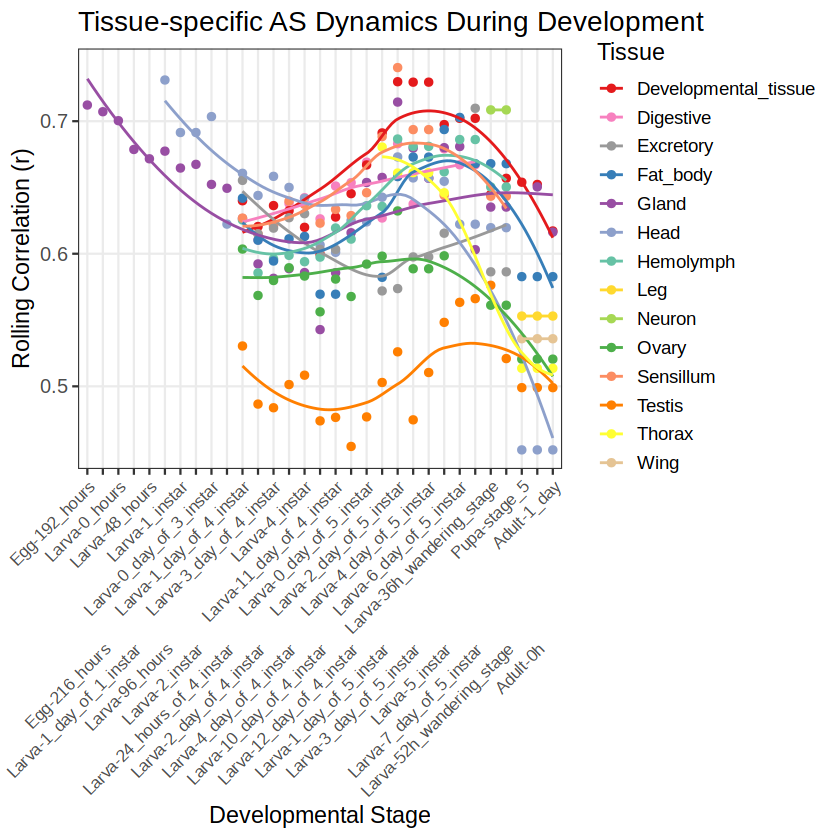

In [22]:
p <- ggplot(corr_results_filtered, 
            aes(x = Combined_Stage, y = cor_value, color = Tissue, group = Tissue)) +
  geom_point(size = 2) +
  geom_smooth(
    method = "loess", 
    se = FALSE, 
    span = 1, 
    aes(group = Tissue),
    linewidth = 0.8
  ) +
  scale_color_manual(values = tissue_color_mapping) +  # 应用颜色映射
  theme_bw(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 12),
    legend.position = "right",
    panel.grid.minor = element_blank()
  ) +
  labs(
    x = "Developmental Stage",
    y = "Rolling Correlation (r)",
    title = "Tissue-specific AS Dynamics During Development"
  ) +
  scale_x_discrete(guide = guide_axis(n.dodge = 2))  # 防止x轴标签重叠
print(p)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 217 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 28.99”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.01”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0401”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, para

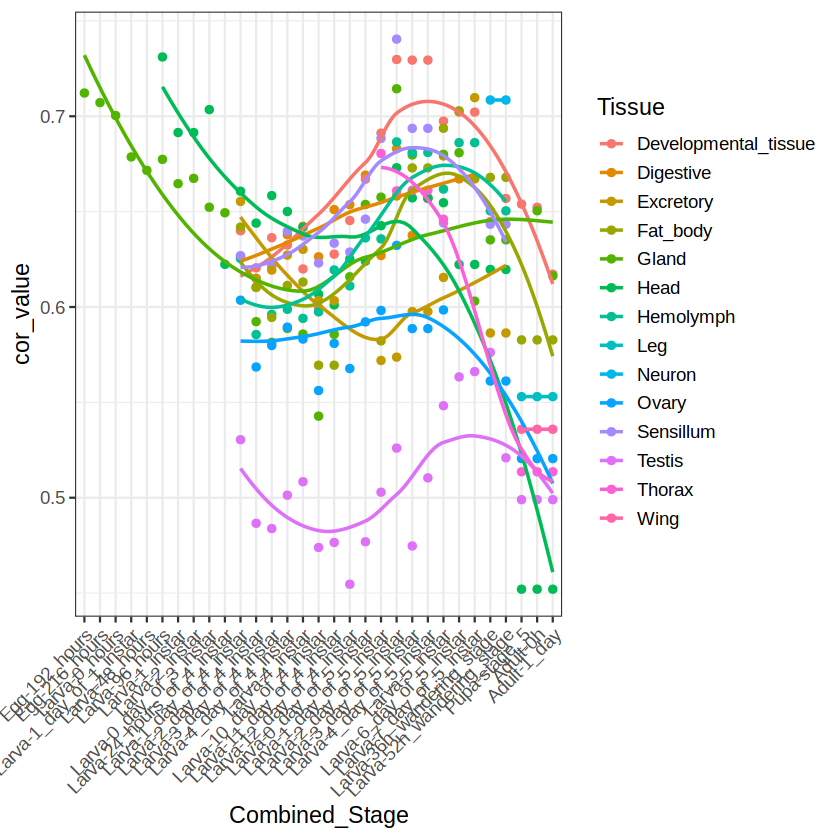

In [93]:
p <- ggplot(corr_results_filtered, 
            aes(x = Combined_Stage, y = cor_value, color = Tissue, group = Tissue)) +
  geom_point(size = 2) +
  geom_smooth(method = "loess", se = FALSE, span = 1, aes(group = Tissue)) +
  theme_bw(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)

In [23]:
ggsave("Fig3-A.pdf", plot = p, width = 8, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 217 rows containing non-finite values (`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 28.99”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.01”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0401”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, para